# TP3 - Make your own Similar Image Search Engine (SISE)

The objective of this TP is two-fold:

- demonstrate that trained neural networks yield **excellent features/representations**,
- get familiar with the concept of **transfer learning**, where the knowledge of a model trained on dataset **A** is leveraged for downstream tasks on an unseen dataset **B**.

To do so, we are going to exploit the features of a model pretrained on the classification [ImageNet dataset](https://image-net.org/) (dataset **A**), a largescale dataset of 1k classes and 1M samples. We will show that such a model has learned general features that can be re-used for other tasks and datasets. In particular in this TP, we will build our own **Similar Image Search Engine (SISE)** which is defined as a system taking as input an image and outputs the *K* most similar images in the database, The most popular SISE is the powerful *Google image search* which you can try at [https://www.google.com/imghp?](https://www.google.com/imghp?). For memory/computational reasons, we will use the small [Caltech101 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) (dataset **B**) as our reference database. Transfer learning is especially important since it has been shown to (i) generalize well to unseen target datasets and (ii) stabilize and fasten training on more complex tasks.

Check you are running the notebook on a GPU:

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch

USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
device = torch.device('cuda') if (USE_GPU and torch.cuda.is_available()) else torch.device('cpu')
print('using device:', device)

using device: cuda


## A. Naive implementation

In this part, we implement a naive SISE algorithm. We will first explore and prepare our dataset and then use the classical L2-distance in pixel space to compute similarity between images.

### A.1. Explore and prepare Caltech101 dataset

The target dataset is [Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), a 8k image classification dataset of 101 classes. The package `torchvision` allows to easily download, and read the data.

In [2]:
from torchvision.datasets import Caltech101
import torchvision.transforms as T

class ToRGB:
    def __call__(self, image):
        return image.convert('RGB')

tsf = T.Compose([ToRGB(), T.Resize((224, 224))])
"""
!wget https://imagine.enpc.fr/~vincente/caltech101.zip
!mkdir -p "./data"
!unzip -qq "caltech-101.zip" -d "./data"
!rm "caltech-101.zip"
"""
raw_dataset = Caltech101(root='./data', transform=tsf, download=True)
class_mapping = raw_dataset.categories

100%|██████████| 137M/137M [00:02<00:00, 57.3MB/s]


**Q1.a.** Explore the dataset by (i) printing the dataset size and the image size, and (ii) vizualizing 25 random images with their associated classes as titles. You should use previous ```class_mapping``` dictionary to show real class labels.

dataset size : 8677
image size : (224, 224)


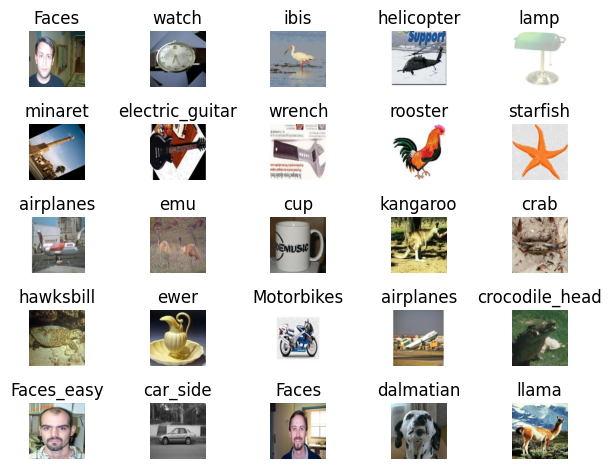

In [3]:
### Your code ###
print("dataset size :", len(raw_dataset))

img, label = raw_dataset[0]
print("image size :", img.size)

fig, axes = plt.subplots(5, 5)

for ax in axes.flatten():
    img, label = raw_dataset[np.random.randint(0,8677)]


    ax.imshow(img)
    ax.set_title(class_mapping[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

**Q1.b.** As always we need to normalize data, the following cell instanciates a new dataset that is normalized with precomputed mean and std, as well a Dataloader of batch_size 128. Explain in a few words why we need to normalize data:

**Your answer:...**
# We normalize data because the model was trained on normalized data, this is done to stabilize the feature space.

In [4]:
import torchvision.transforms as T
from torch.utils.data import DataLoader

tsf = T.Compose([ToRGB(), T.Resize((224, 224)), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
proc_dataset = Caltech101(root='./data/', transform=tsf, download=True)

batch_size = 128
loader = DataLoader(proc_dataset, batch_size=batch_size, shuffle=False)

*NB:* note that we resize images to match the image size used to train the model on ImageNet

### A.2. Pixel-based similarity

**Q2.a.** Complete the function `show_images(indices)` which takes as input a list of indices `indices` and plot the corresponding images in the unnormalized dataset `raw_dataset`, titled with their real class label.

In [5]:
def show_images(indices):
  l = math.ceil(np.sqrt(len(indices)))

  fig, axes = plt.subplots(l, l)

  i = 0
  for ax in axes.flatten():
    if i < len(indices):
      img, label = raw_dataset[indices[i]]
      i += 1

      ax.imshow(img)
      ax.set_title(class_mapping[label])
    ax.axis('off')

  plt.tight_layout()
  plt.show()

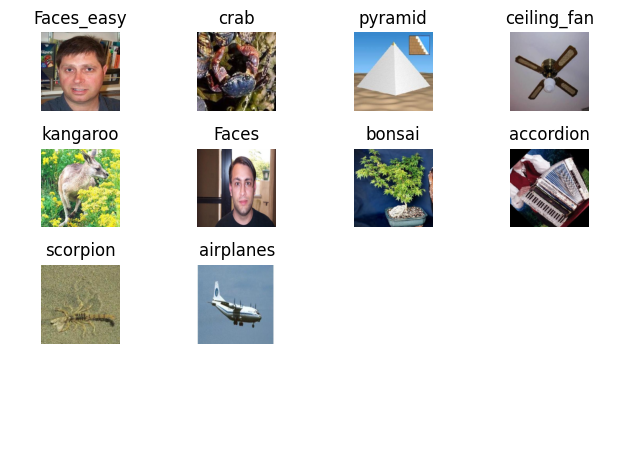

In [ ]:
# Test function
show_images(np.random.choice(8000, 10, replace=False))

**Q2.b.** Complete the function `mse(img, others)` which takes as input an image `img` (tensor of size *CxHxW*), a list of images `others` (tensor of size *BxCxHxW*), and outputs the Mean Square Error (MSE) between `img` and each element in others.

*NB:* don't forget to put the tensors on the cuda `device` to benefit from accelerated computations.

In [6]:
def mse(img, others):

    img = img.to(device)
    others = others.to(device)

    img = img.unsqueeze(0)
    diff = others - img
    diff = torch.square(diff)
    diff = torch.mean(diff, dim=(1, 2, 3))

    return diff

In [7]:
# Test function
assert mse(torch.rand(3, 64, 64), torch.rand(10, 3, 64, 64)).shape == torch.zeros(10).shape

**Q2.c.** Complete the function `naive_retrieve_similar(img, dataset, K)` which takes as input an tensor image `img`, a pytorch dataloader `loader`, an integer `K`, and outputs the indices of the *K* most similar images where the similarity is defined by the squared L2-distance implemented above.

In [7]:
def naive_retrieve_similar(img, loader, K=10):
    min_idx, min_dist = [0]*K, [10e6]*K     # We initialize with dummy elements the indices yielding the minimal distance and corresponding distances

    global_idx = 0

    for batch, (inp, label) in enumerate(loader):

        dists = mse(img, inp)
        batch_size = dists.size(0)

        for i in range(batch_size):
            d = dists[i].item()
            worst = max(min_dist)
            if d < worst:
                worst_pos = min_dist.index(worst)
                min_dist[worst_pos] = d
                min_idx[worst_pos]  = global_idx + i

        global_idx += batch_size

    return min_idx

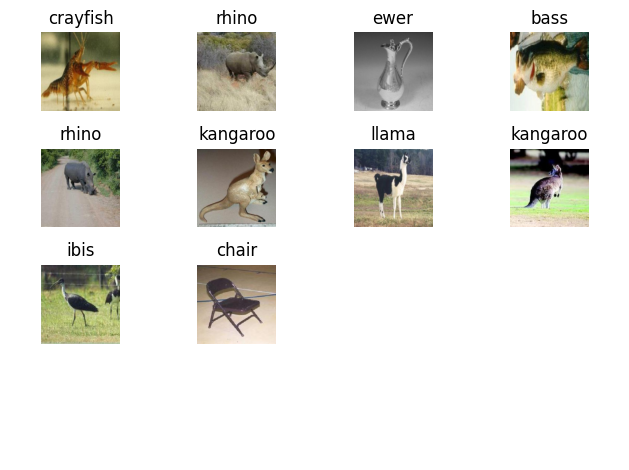

In [ ]:
# Single test
show_images(naive_retrieve_similar(proc_dataset[5818][0], loader))

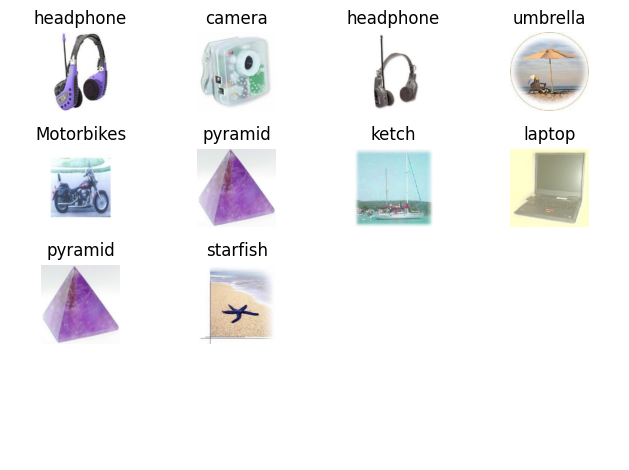

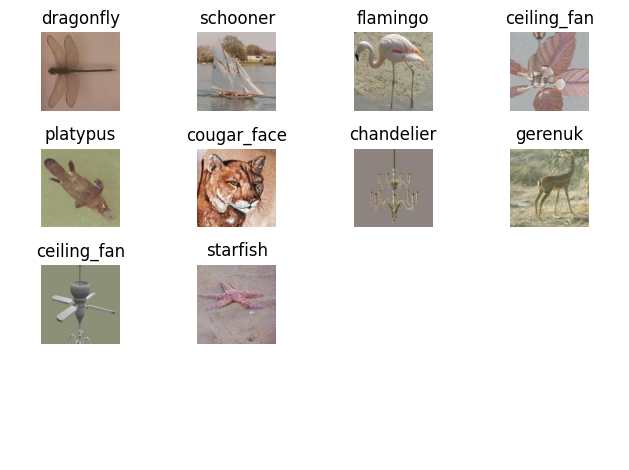

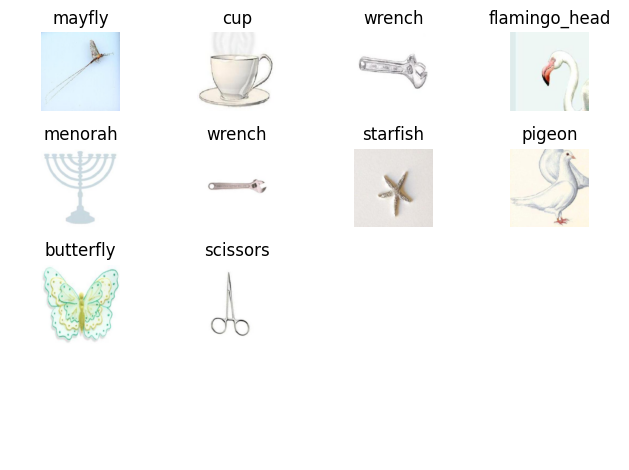

In [ ]:
# Test function (should take less than 5 minutes)
show_images(naive_retrieve_similar(proc_dataset[5464][0], loader))
show_images(naive_retrieve_similar(proc_dataset[4037][0], loader))
show_images(naive_retrieve_similar(proc_dataset[4283][0], loader))

**Q2.d.** Briefly analyse and comments your results.

**Your answer: ...**
# The naive retreiver is bad, only a little better than random, it finds images with similar colour palets but it doesn't get more than 2/10 of the classes right.

## B. Leveraging a pretrained NN

In this part, we will use a pytorch model pretrained on ImageNet and available through the ```torchvision``` package (more info [here]((https://pytorch.org/vision/stable/models.html)). These models have been trained on GPUs for several days/weeks with carefully selected hyperparameters to produce the best results. We chose to work with a [ResNet-18](https://arxiv.org/abs/1512.03385) architecture which has the advantage to give decent results on ImageNet (69.7% accuracy) and to be relatively small in terms of GPU memory.

### B.1. Load and prepare network

**Q3.a.** Load a pretrained ResNet-18 model using ``torchvision`` (see doc at https://pytorch.org/vision/stable/models.html), put it in evaluation mode (see [here](https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch) for more info) and move it to the cuda `device`:

In [8]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

model.eval()
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


Run the following cell to install a useful library to vizualize the architecture of the model:

In [9]:
!pip install torchsummary
from torchsummary import summary
# Shape of an image is 224x224 with 3 RGB channels
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

**Q3.b.** How many parameters are there in the loaded model? How many convolutional layers? What is the number of channels before the final linear layer?

**Your answer: ...**
# There are 11,689,512 parameters, 20 convolutional layers in total, and 512 channels before the final linear layer.

**Q3.c.** For a classification network, the last linear layer is called a *classification head*: it maps a vector from a feature space to a vector in the class space. In our case where classes don't necessarily correspond to the classes of the loaded model, we would like to directly use the output feature instead of the classification head output. We do it through the following cell, please read and briefly describe it:

**Your answer: ...**
# We remove the classification head, so the model outputs the final convolutional features (conv5 feature map, shape 512×7×7).

In [10]:
from torch import nn

class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

model.avgpool = Identity()
model.fc = Identity()

### B.2. Feature-based similarity

**Q4.a.** Complete the function ```nn_retrieve_similar(img, dataset, K)``` which takes as input an tensor image ```img```, a pytorch dataloader ```loader```, and outputs the indices of the K most similar images where the similarity is defined by the MSE in the NN feature space.

In [11]:
def nn_retrieve_similar(img, loader, K=10):
    min_idx, min_dist = [0]*K, [10e6]*K     # We initialize with dummy elements the indices yielding the minimal distance and corresponding distances

    x = img.unsqueeze(0).to(device)
    feat = model(x)
    feat = torch.flatten(feat, 1)
    global_idx = 0

    for batch, (inp, label) in enumerate(loader):

        inp = inp.to(device)

        feats = model(inp)
        feats = torch.flatten(feats, 1)

        diff  = feats - feat
        dists = (diff ** 2).mean(dim=1)

        for i, d in enumerate(dists):
            d_val = d.item()
            worst = max(min_dist)
            if d_val < worst:
                worst_pos = min_dist.index(worst)
                min_dist[worst_pos] = d_val
                min_idx[worst_pos]  = global_idx + i

        global_idx += inp.size(0)

    return min_idx

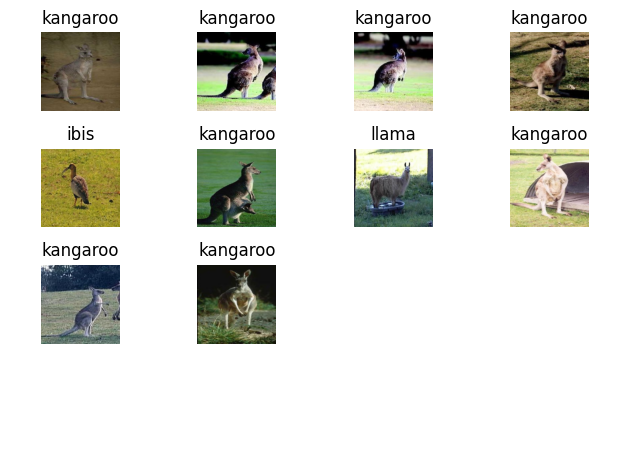

In [ ]:
# Single test
show_images(nn_retrieve_similar(proc_dataset[5818][0], loader))

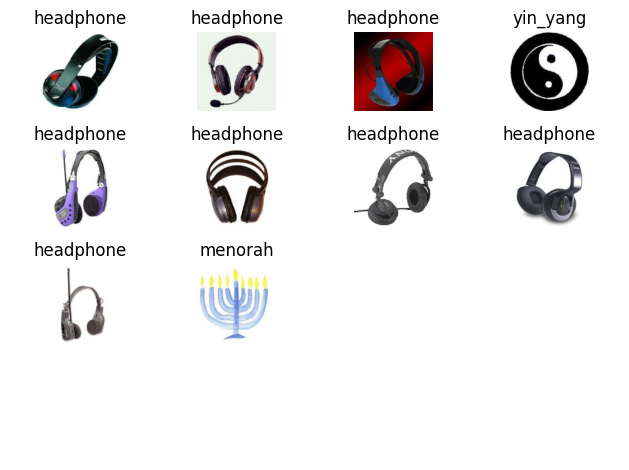

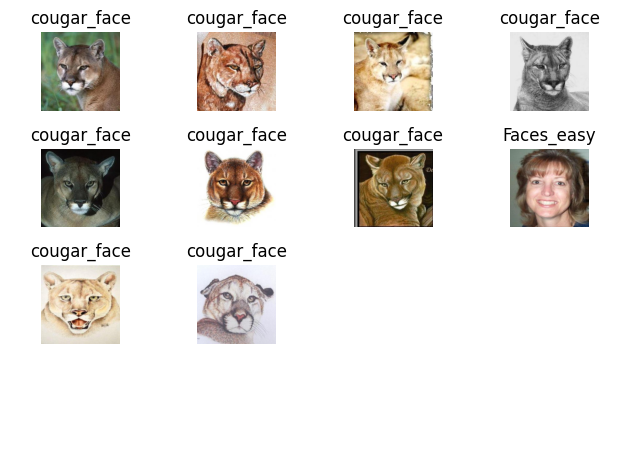

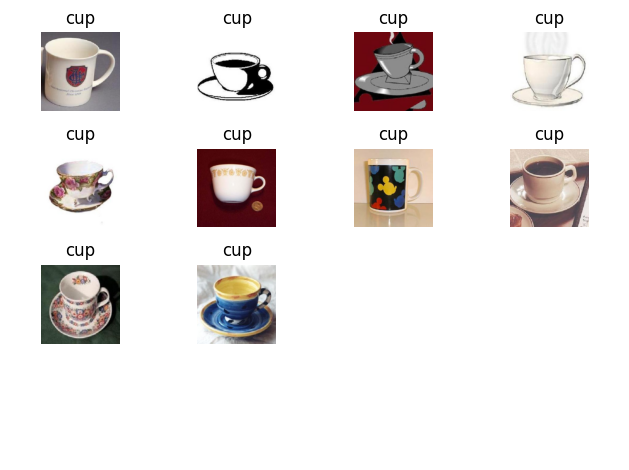

In [ ]:
# Test function (should take less than 5 minutes)
show_images(nn_retrieve_similar(proc_dataset[5464][0], loader))
show_images(nn_retrieve_similar(proc_dataset[4037][0], loader))
show_images(nn_retrieve_similar(proc_dataset[4283][0], loader))

**Q4.b.** Analyze and briefly comment your results.

**Your answer:...**
# This is much better with a score of 8.75/10 ! This is particularly impressive because the classes cougar_face and headphones are not in ImageNet. This proves a capacity to generalize understanding of images beyond classes it was trained on.
# We also notice that it is better at classifying cups, this is expected as ImageNet was trained on cup images.
# We also notice that 3/5 of the mistakes were made on images from classes that ImageNet did not train on. This seems normal as it hasn't been optimized to discriminate between them.

**Q5.a.** It exists many distances to compare vectors in high dimensional space. One distance commonly used to compare NN features is the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Implement a new function `nn_retrieve_similar_cos(img, dataset, K)` which uses the cosine similarity instead of L2-distance:

In [12]:
import torch.nn.functional as F

def nn_retrieve_similar_cos(img, dataset, K=10):
    min_idx, min_dist = [0]*K, [10e6]*K     # We initialize with dummy elements the indices yielding the minimal distance and corresponding distances

    x = img.unsqueeze(0).to(device)
    feat = model(x)
    feat = torch.flatten(feat, 1)
    global_idx = 0

    for batch, (inp, label) in enumerate(dataset):

        inp = inp.to(device)

        feats = model(inp)
        feats = torch.flatten(feats, 1)

        cos_sim = F.cosine_similarity(feats, feat)
        dists = 1 - cos_sim

        for i, d in enumerate(dists):
            d_val = d.item()
            worst = max(min_dist)
            if d_val < worst:
                worst_pos = min_dist.index(worst)
                min_dist[worst_pos] = d_val
                min_idx[worst_pos]  = global_idx + i

        global_idx += inp.size(0)

    return min_idx

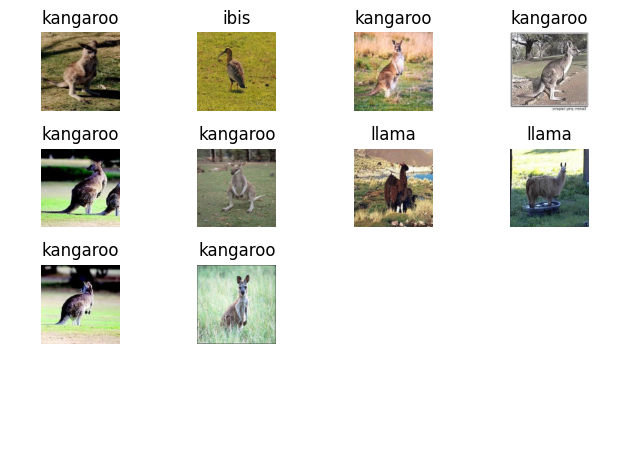

In [ ]:
# Single test
show_images(nn_retrieve_similar_cos(proc_dataset[5818][0], loader))

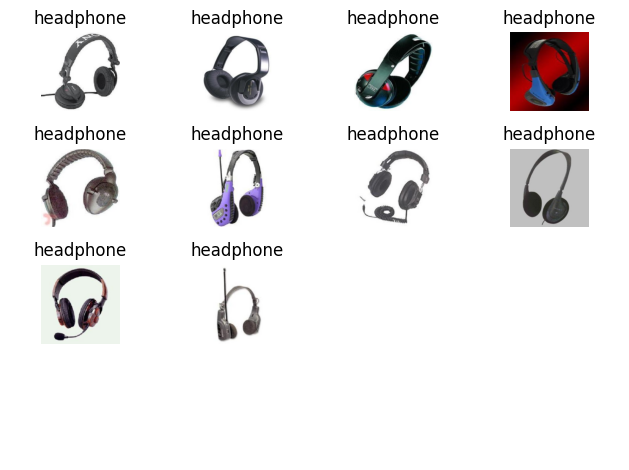

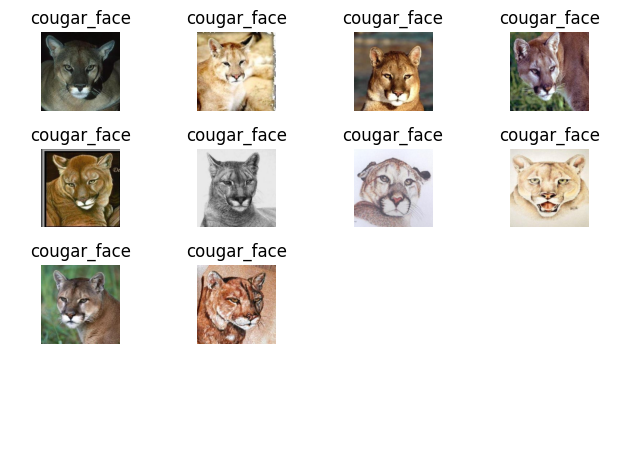

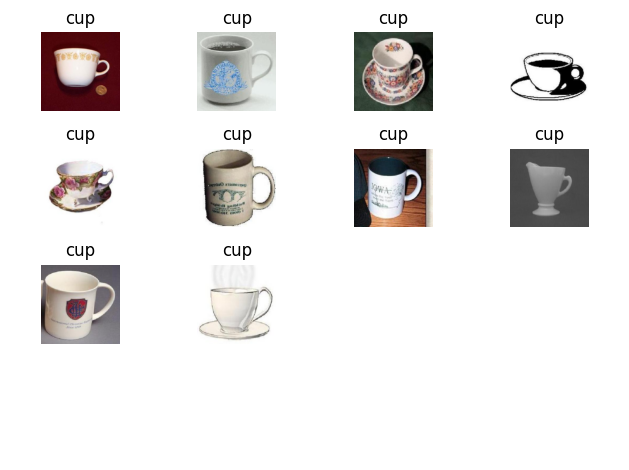

In [ ]:
# Test function (may take a few minutes, you may want to try other samples)
show_images(nn_retrieve_similar_cos(proc_dataset[5464][0], loader))
show_images(nn_retrieve_similar_cos(proc_dataset[4037][0], loader))
show_images(nn_retrieve_similar_cos(proc_dataset[4283][0], loader))

**Q5.b.** Analyze and briefly comment your results.

**Your answer:...**
# We now have a score of 9.25/10 but the global way it works is very similar to before just with a different distance metric.
# This new metric prioritizes direction over norm.

## C. Going further (bonus if no time)

A limited number of points will be attributed for the following questions.

**Q6.a.** Propose a metric to quantitatively evaluate our SISE.

**Your answer: ...**
# We can evaluate our SISE models with a percent of correct answers in the K-clossest for all images in the dataset.

**Q6.b.** Implement it and evaluate your best SISE.

In [13]:
def compute_features(loader, model):
    feats = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in loader:

            imgs = imgs.to(device)
            f = model(imgs)
            f = torch.flatten(f, 1)

            feats.append(f)
            labels.append(lbls)

    feats = torch.cat(feats)
    labels = torch.cat(labels)
    return feats, labels

feats, labels = compute_features(loader, model)

In [18]:
# vectorizing the process is capital. It would have taken me 2.7 days to evaluate by going image by image.
# I wasn't able to do this while using the actual function coded above, this is why I recoded the mse and cos.
def eval_SISE_cos(features, labels, K=10):
    features = features.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        feats_norm = F.normalize(features, p=2, dim=1)

        sim = feats_norm @ feats_norm.T
        sim.fill_diagonal_(-1.0)

        vals, idxs = torch.topk(sim, K, dim=1, largest=True)
        retrieved_labels = labels[idxs]
        same = (retrieved_labels == labels.unsqueeze(1))
        precisions = same.float().mean(dim=1)

        return precisions.mean().item()


def eval_SISE_mse(features, labels, K=10):
    features = features.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        X = features

        x2 = (X ** 2).sum(dim=1, keepdim=True)
        dists = x2 + x2.T - 2.0 * (X @ X.T)
        dists.fill_diagonal_(float("inf"))

        _, idxs = torch.topk(dists, K, dim=1, largest=False)
        retrieved_labels = labels[idxs]
        same = (retrieved_labels == labels.unsqueeze(1))
        precisions = same.float().mean(dim=1)

        return precisions.mean().item()

print("cos SISE score : ", eval_SISE_cos(feats, labels))

print("mse SISE score : ",eval_SISE_mse(feats, labels))

cos SISE score :  0.8678114414215088
mse SISE score :  0.7740578651428223


**Q7.a.** We arbitrarly used the features obtained before the final pooling and linear layers, which are also known as **conv5 features** as output of the 5th convolutional block. Implement and evaluate a similarity computed on **conv4 feature** by setting the approriate layers to identity.

*NB:* you can retrieve the list of module names with `[n for n, k in model.named_modules()]`

In [15]:
model_2 = resnet18(weights=ResNet18_Weights.DEFAULT)
model_2.layer4 = nn.Identity()
model_2.avgpool = nn.Identity()
model_2.fc = nn.Identity()

model_2 = model_2.to(device).eval()
feats_2, labels_2 = compute_features(loader, model_2)

print("cos SISE score : ", eval_SISE_cos(feats_2, labels_2))

print("mse SISE score : ",eval_SISE_mse(feats_2, labels_2))

cos SISE score :  0.6743690371513367
mse SISE score :  0.5416503548622131


**Q7.b.** Analyze and briefly comment your results.

**Your answer:...**

# The score here is a lot less good. This is because the layer before is more conceptual and gives general characteristics about the image rather than information about specific paterns or shapes on the image that the last layer does output.

# Going further :

Concatenating the outputs of layer 3 and layer 4 proved to be oly ever so slightly effective with a 0.005 gain to the score.

In [17]:

combined_feats = torch.cat([feats_2, feats], dim=1)

eval_cos = eval_SISE_cos(combined_feats, labels, K=10)
print("(conv4+conv5, cosine):", eval_cos)

combined_feats = torch.cat([feats_2, feats], dim=1)

eval_mse = eval_SISE_mse(combined_feats, labels, K=10)
print("(conv4+conv5, MSE):", eval_mse)

(conv4+conv5, cosine): 0.8698397278785706
(conv4+conv5, MSE): 0.7802120447158813


# New approache :
# We retrain the layer4 and final fc layer of the ImageNet specificaly for Caltech101.

In [ ]:
from torch.utils.data import random_split, DataLoader

full_dataset = proc_dataset
num_classes = len(class_mapping)

N = len(full_dataset)
n_train = int(0.8 * N)
n_val   = N - n_train

train_set, val_set = random_split(
    full_dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(0)
)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=64, shuffle=False, num_workers=2)

In [ ]:
ft_model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Replace classification head for Caltech101
in_features = ft_model.fc.in_features
ft_model.fc = nn.Linear(in_features, num_classes)

ft_model = ft_model.to(device)

# Freeze early layers, fine-tune only layer4 + fc
for name, param in ft_model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, ft_model.parameters()),
                             lr=1e-4)

def train_one_epoch(model, loader):
    model.train()
    running_loss, running_correct, n = 0.0, 0, 0

    for imgs, labels in loader:
        imgs   = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            preds = outputs.argmax(dim=1)
            running_loss   += loss.item() * imgs.size(0)
            running_correct += (preds == labels).sum().item()
            n += imgs.size(0)

    return running_loss / n, running_correct / n

def eval_classifier(model, loader):
    model.eval()
    running_loss, running_correct, n = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs   = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)
            running_loss   += loss.item() * imgs.size(0)
            running_correct += (preds == labels).sum().item()
            n += imgs.size(0)

    return running_loss / n, running_correct / n

num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(ft_model, train_loader)
    val_loss,   val_acc   = eval_classifier(ft_model, val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- train loss {train_loss:.3f}, acc {train_acc:.3f} "
          f"- val loss {val_loss:.3f}, acc {val_acc:.3f}")

Epoch 1/5 - train loss 2.036, acc 0.625 - val loss 0.901, acc 0.857
Epoch 2/5 - train loss 0.530, acc 0.938 - val loss 0.435, acc 0.934
Epoch 3/5 - train loss 0.203, acc 0.985 - val loss 0.323, acc 0.949
Epoch 4/5 - train loss 0.091, acc 0.996 - val loss 0.266, acc 0.953
Epoch 5/5 - train loss 0.047, acc 0.999 - val loss 0.251, acc 0.951


In [ ]:
import copy
import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x

feature_model = copy.deepcopy(ft_model)
feature_model.avgpool = Identity()
feature_model.fc      = Identity()
feature_model = feature_model.to(device).eval()

feats_3, labels_3 = compute_features(loader, feature_model)

print("cos SISE score : ", eval_SISE_cos(feats_3, labels_3))
print("mse SISE score : ", eval_SISE_mse(feats_3, labels_3))

cos SISE score :  0.9847182631492615
mse SISE score :  0.9754638075828552


# This has proved to be extremely effective, for less than 1 minute of gpu usage we have an extraordinarily high score of 98.5% compared to 87% before.
# Also, the actual image categorisation is very good. Last TP after 40 minutes of training we got to 86% correstness, here in 1 minute of fine tuning we reached 95% !
